## Проект 5. Компьютер говорит «Нет»

## 1. Импорт библиотек

In [1]:
from pandas import Series
import pandas as pd
import numpy as np
import pandas_profiling

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

## 2. Импорт данных

In [2]:
train = pd.read_csv("./train.csv")

In [3]:
'''
Описания полей датасета

client_id - идентификатор клиента
education - уровень образования
sex - пол заемщика
age - возраст заемщика
car - флаг наличия автомобиля
car_type - флаг автомобиля иномарки
decline_app_cnt - количество отказанных прошлых заявок
good_work - флаг наличия “хорошей” работы
bki_request_cnt - количество запросов в БКИ
home_address - категоризатор домашнего адреса
work_address - категоризатор рабочего адреса
income - доход заемщика
foreign_passport - наличие загранпаспорта
default - наличие дефолта
'''

'\nОписания полей датасета\n\nclient_id - идентификатор клиента\neducation - уровень образования\nsex - пол заемщика\nage - возраст заемщика\ncar - флаг наличия автомобиля\ncar_type - флаг автомобиля иномарки\ndecline_app_cnt - количество отказанных прошлых заявок\ngood_work - флаг наличия “хорошей” работы\nbki_request_cnt - количество запросов в БКИ\nhome_address - категоризатор домашнего адреса\nwork_address - категоризатор рабочего адреса\nincome - доход заемщика\nforeign_passport - наличие загранпаспорта\ndefault - наличие дефолта\n'

## 3. Предварительный анализ данных

In [4]:
pandas_profiling.ProfileReport(train) 

Summarize dataset:   0%|          | 0/27 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 4. Анализ по переменным

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   client_id         73799 non-null  int64 
 1   education         73492 non-null  object
 2   sex               73799 non-null  object
 3   age               73799 non-null  int64 
 4   car               73799 non-null  object
 5   car_type          73799 non-null  object
 6   decline_app_cnt   73799 non-null  int64 
 7   good_work         73799 non-null  int64 
 8   bki_request_cnt   73799 non-null  int64 
 9   home_address      73799 non-null  int64 
 10  work_address      73799 non-null  int64 
 11  income            73799 non-null  int64 
 12  foreign_passport  73799 non-null  object
 13  default           73799 non-null  int64 
dtypes: int64(9), object(5)
memory usage: 7.9+ MB


In [6]:
# Как мы видим, пропуски встречаются только в информации об образовании клиентов. 

# Отсутсвие образования может быть важным фактором, создаем бинарную переменную
train['education_nan'] = pd.isna(train['education']).astype('uint8')

# Заполняем образование самым распространеным школьным 'SCH'
train['education'] = train['education'].fillna('SCH')

# TODO - найти образование через обучение модели

In [7]:
# Полученные признаки сгруппируем в три категории по типу их обработки 
# (категориальные, бинарные и числовые) для дальнейшего удобного анализа.

# бинарные переменные
bool_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'education_nan']

# категориальные переменные
cat_cols = ['education', 'home_address', 'work_address']

# числовые переменные
num_cols = ['age', 'decline_app_cnt', 'income','bki_request_cnt']

### Посмотрим распределение числовых данных:

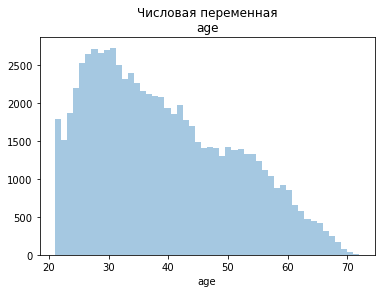

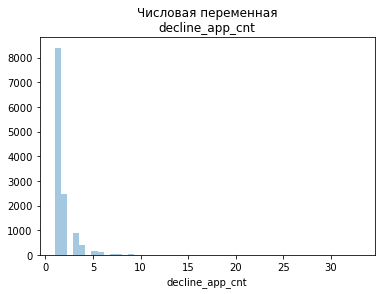

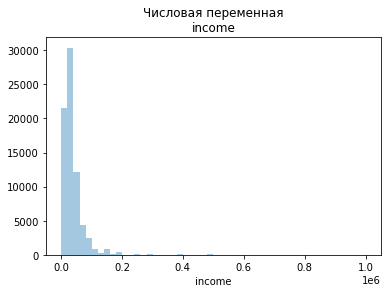

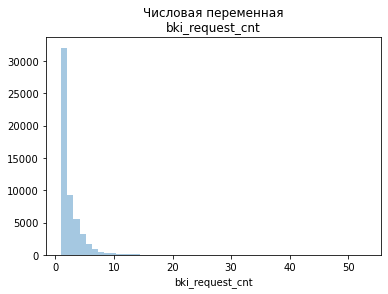

In [8]:
for i in num_cols:
    plt.figure()
    sns.distplot(train[i][train[i] > 0].dropna(), kde = False, rug=False)
    plt.title('Числовая переменная\n' + i)
    plt.show()

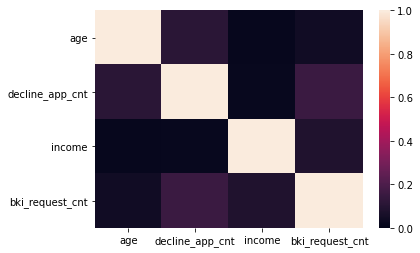

In [9]:
# Оценим корреляцию Пирсона для непрерывных переменных:
sns.heatmap(train[num_cols].corr().abs(), vmin=0, vmax=1)

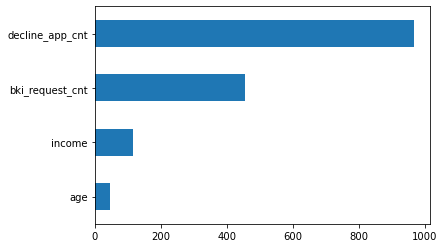

In [10]:
# В качестве меры значимости мы будем использовать значение f-статистики. Чем значение статистики выше, 
# тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей линейной модели.
imp_num = pd.Series(f_classif(train[num_cols], train['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

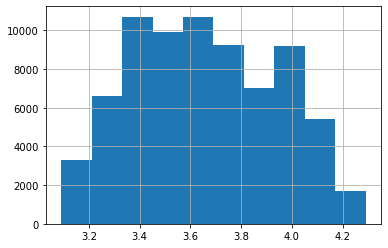

In [11]:
# логарифмируем возвраст
train['age'] = np.log(train['age'] + 1)
# строим график после логарифмирования
train['age'].hist()

# Распределение логнормальное, в модель пойдет логарифм от признака

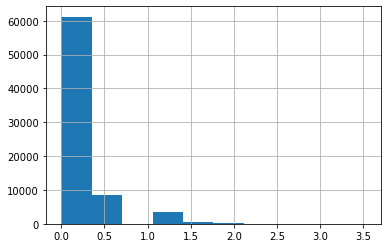

In [12]:
# логарифмируем количество отказов прошлых заявок
train['decline_app_cnt'] = np.log(train['decline_app_cnt'] + 1)
# строим график после логарифмирования
train['decline_app_cnt'].hist()

# Распределение логнормальное, в модель пойдет логарифм от признака

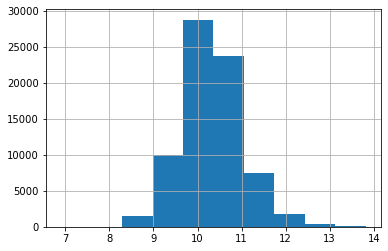

In [13]:
# логарифмируем доход
train['income'] = np.log(train['income'] + 1)
# строим график после логарифмирования
train['income'].hist()

# Распределение логнормальное, в модель пойдет логарифм от признака

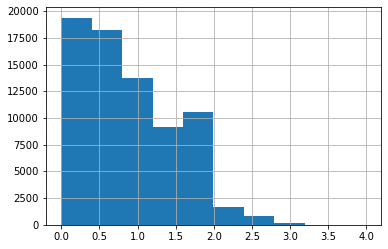

In [14]:
# логарифмируем количество запросов в БКИ
train['bki_request_cnt'] = np.log(train['bki_request_cnt'] + 1)
# строим график после логарифмирования
train['bki_request_cnt'].hist()

# Распределение логнормальное, в модель пойдет логарифм от признака

In [15]:
train.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default,education_nan
0,25905,SCH,M,4.143135,Y,Y,0.000000,0,0.693147,1,2,9.798183,N,0,0
1,63161,SCH,F,4.094345,N,N,0.000000,0,1.386294,2,3,9.852247,N,0,0
2,25887,SCH,M,3.258097,Y,N,1.098612,0,0.693147,1,2,10.308986,Y,0,0
3,16222,SCH,F,3.988984,N,N,0.000000,0,1.098612,2,3,9.210440,N,0,0
4,101655,GRD,M,3.891820,N,N,0.000000,1,0.693147,2,3,10.308986,Y,0,0


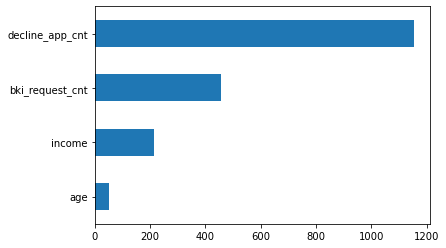

In [16]:
imp_num = pd.Series(f_classif(train[num_cols], train['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

### Посмотрим распределение бинарных переменных:

In [17]:
# бинарные переменные
# bool_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'education_nan']

In [18]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in bool_cols:
    train[column] = label_encoder.fit_transform(train[column])
    
# убедимся в преобразовании    
train.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default,education_nan
0,25905,SCH,1,4.143135,1,1,0.000000,0,0.693147,1,2,9.798183,0,0,0
1,63161,SCH,0,4.094345,0,0,0.000000,0,1.386294,2,3,9.852247,0,0,0
2,25887,SCH,1,3.258097,1,0,1.098612,0,0.693147,1,2,10.308986,1,0,0
3,16222,SCH,0,3.988984,0,0,0.000000,0,1.098612,2,3,9.210440,0,0,0
4,101655,GRD,1,3.891820,0,0,0.000000,1,0.693147,2,3,10.308986,1,0,0


### Пол

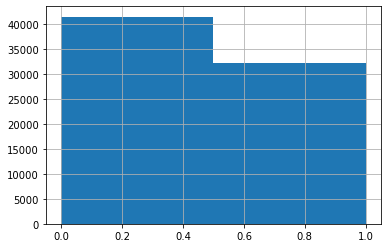

In [19]:
# Пол
train['sex'].hist(bins=2)

In [20]:
# из датасета видно, что клиентов женщин больше

### Ааавтомобиль

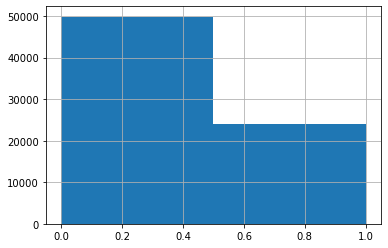

In [21]:
train['car'].hist(bins=2)

In [22]:
# из датасета видно, что клиентов без машины больше

### Автомобиль иномарка или отечественный

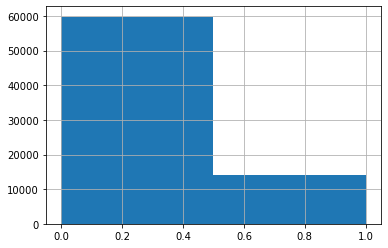

In [23]:
train['car_type'].hist(bins=2)

In [24]:
# отечественных автомобилей большинство

### Наличие "хорошей" работы

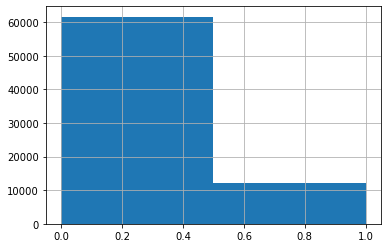

In [25]:
train['good_work'].hist(bins=2)

In [26]:
# большинство клиентов не имеют метки хорошая работа

### Наличие загранпаспорта

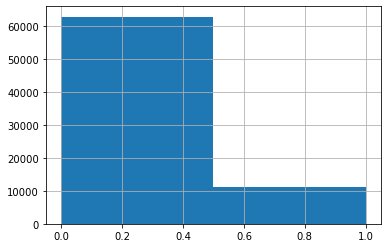

In [27]:
train['foreign_passport'].hist(bins=2)

In [28]:
# большинство клинетов не имеет загранпаспорта

### Отсутствие образования

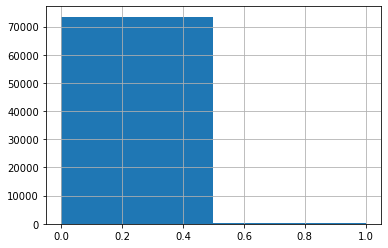

In [29]:
train['education_nan'].hist(bins=2)

In [30]:
# из предварительного анализа помним что у 307 человек нет образования

### Посмотрим распределение категориальных переменных:

In [31]:
# категориальные переменные
# ['education', 'home_address', 'work_address']

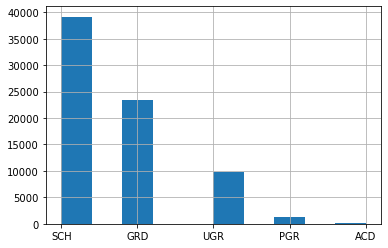

In [32]:
# Образование
train['education'].hist()

In [33]:
# чем ниже уровень образования тем больше кредитов

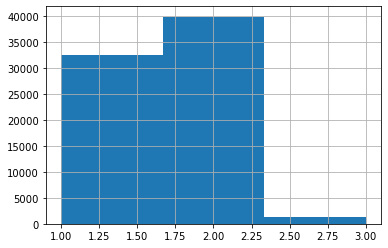

In [34]:
# Домашний адресс
train['home_address'].hist(bins=3)

In [35]:
# клиенты из базы живут всего в 3 зонах

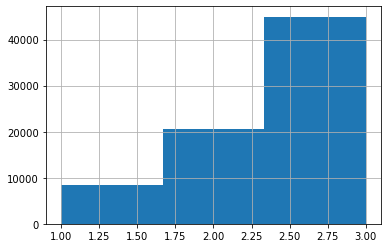

In [36]:
# Рабочий адресс
train['work_address'].hist(bins=3)

In [37]:
# рабочие места сконцентрированны по большей части в одной зоне

# 5. Подготовка данных к машинному обучению

In [100]:
'''# реализуем метод OneHotLabels через get_dummies для бинарных и категориальных переменных
train = pd.read_csv("./train.csv")
train=pd.get_dummies(train)
# стандартизируем числовые переменные
train[num_cols] = pd.DataFrame(StandardScaler().fit_transform(train[num_cols]),columns = train[num_cols].columns)
# Объединяем
X = train[list(set(train.columns)-set(['default']))].values
Y = train['default'].values'''

In [113]:
train = pd.read_csv("./train.csv")

label_encoder = LabelEncoder()

mapped_education = pd.Series(label_encoder.fit_transform(train['sex']))
print(dict(enumerate(label_encoder.classes_)))

{0: 'F', 1: 'M'}


In [118]:
# Для бинарных признаков мы будем использовать LabelEncoder
label_encoder = LabelEncoder()
# бинарные переменные
bool_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
# Заполняем образование самым распространеным школьным 'SCH'
train['education'] = train['education'].fillna('SCH')

for column in bool_cols:
    train[column] = label_encoder.fit_transform(train[column])
    
# убедимся в преобразовании    
train.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,25905,SCH,1,62,1,1,0,0,1,1,2,18000,0,0
1,63161,SCH,0,59,0,0,0,0,3,2,3,19000,0,0
2,25887,SCH,1,25,1,0,2,0,1,1,2,30000,1,0
3,16222,SCH,0,53,0,0,0,0,2,2,3,10000,0,0
4,101655,GRD,1,48,0,0,0,1,1,2,3,30000,1,0


In [119]:
# Эта техника реализована в sklearn.preprocessing в классе OneHotEncoder. 
# По умолчанию OneHotEncoder преобразует данные в разреженную матрицу, 
# чтобы не расходовать память на хранение многочисленных нулей.
X_cat = OneHotEncoder(sparse = False).fit_transform(train[cat_cols].values)

In [126]:
# Стандартизация числовых переменных
X_num = StandardScaler().fit_transform(train[num_cols].values)

In [128]:
# Объединяем

X = np.hstack([X_num, train[bool_cols].values, X_cat])
Y = train['default'].values

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

### Оборачивание логистической регрессии в класс

In [130]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

In [131]:
def print_logisitc_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f'acc = {acc:.2f} F1-score = {f1:.2f}')

In [132]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X,Y)
print_logisitc_metrics( Y, lr.predict(X))

acc = 0.87 F1-score = 0.02


F:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


F:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


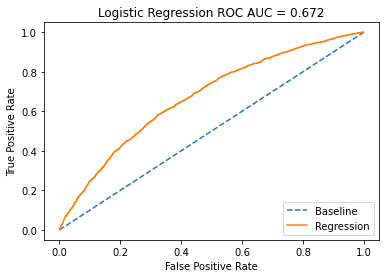

In [133]:
model = LogisticRegression()
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [134]:
logreg_0 = LogisticRegression()
logreg_0.fit(X_train, y_train)
y_pred_0 = logreg_0.predict(X_test)
print_logisitc_metrics(y_test, y_pred_0)
display(confusion_matrix(y_test, y_pred_0))

acc = 0.88 F1-score = 0.02


F:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([[12907,    26],
       [ 1810,    17]], dtype=int64)

In [135]:
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

F:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
F:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "F:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "F:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    sol

F:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "F:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "F:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "F:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
F:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. Th

Лучшее Penalty: l2
Лучшее C: 1.0


F:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
